In [2]:
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split
import re
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks', palette='Set2')
import sys
from tqdm.auto import tqdm
np.random.seed(42)
plt.style.use('ggplot')
import scipy.stats as stats

In [3]:
sys.path.append('../utility')
from concordance_index import concordance_index
from regression_line import abline
from repeated_analysis import repeated_analysis
from cross_validate_random_forest import cross_validate_random_forest
from string_utils import multiple_replace

In [5]:
!pwd

/cluster/majf_lab/mtinti/extend_UTRs/ML/TB


In [6]:
df = pd.read_pickle('ML_DATASET_TB.pkl')

In [4]:
#good_index = pd.read_pickle('../../ML_DATASET_TB.pkl')['utr_3']
#good_index

In [5]:
df = pd.read_pickle('ML_DATASET_TB.pkl')
df['good']=[True if n.startswith('Tb927.') else False for n in df.index.values] 
df=df[df['good']]
df=df.dropna()
print(df.shape)
df.head()

(6560, 53)


,mean_ribo,mean_rna,TE,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,...,utr_5_count_tracts_A_mismatch_0,utr_5_count_tracts_C_mismatch_0,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,third_base_A,third_base_T,third_base_G,third_base_C,non_optimal_codon,good
Tb927.3.5260,17.065100,45.851210,0.271235,TGAACAGTTGTGAAGTTAGGACGGGGCGTATGTTGCCTTCCTTTTG...,CTTCCTTTCTTTCTTTTTTCCCCCACCGCTTACTCTTTATCTATAC...,ATGTTAAGTTTTTTGATTGACTGCAGCGAAGACAAAACTGATCTCA...,0.173913,0.451691,0.200483,0.173913,...,0.000000,0.006667,0.020000,0.013333,0.097163,0.092908,0.081560,0.061702,0.355319,True
Tb927.3.5270,44.376535,130.104802,0.254334,AGTGGGCTAACAAACACGGTAGTCGCAACGATAATAACATCGAGCT...,GCCACACGGGGGCGAGCCGATTTGGGTGGTATTTTTTCCTCCCTTC...,ATGAGTAGTGAGAGATATGTGGATGGTGACCTCGGTGAGCCTTTTA...,0.205882,0.379412,0.200000,0.214706,...,0.000000,0.000000,0.013333,0.026667,0.085890,0.092025,0.102249,0.053170,0.306748,True
Tb927.3.5280,57.142513,135.942838,0.295944,TTGGTGTGGGAGAGAATGATTCTAAATGACAAGGGCTGATCATGTG...,AGTGTGCTCTGTTGACACTGTTGGTGTAATTAATCTATTTCAAATA...,ATGACCACGTTCAAGCGGGAAGACCTCCGTCGTGTCTTTTTTAGTG...,0.192802,0.406170,0.177378,0.223650,...,0.000000,0.000000,0.013333,0.000000,0.064350,0.102960,0.078507,0.087516,0.297297,True
Tb927.3.5290,11.424120,35.002112,0.246070,ATGCGTTGAAGAAGGAGAAGCGAATTTTAAGTTTCATGAGTGTGGT...,GTGCTGAATAAGCAGCCGTGTCCACAAAACGAGAAGGAGGCCGGTG...,ATGGGTCGGGCAACAGAGGCACAACGTGCCGAAATGGCAAAGGAGG...,0.190476,0.359307,0.229437,0.220779,...,0.006667,0.000000,0.006667,0.046667,0.080423,0.089242,0.102293,0.061376,0.307937,True
Tb927.3.5300,66.070601,65.183926,0.503378,TGCTATTGGTAGCATTTTCGTTGTTTCATTTCGTAACCTCCTTGAG...,AAAGGATAGCACAGGTCCTCCCCCCTTTTTTCTTGGGCAGTACTCT...,ATGTTATTCACCCGCTGTCTGCTAGCGGTCACGACAATCAACAGTA...,0.181132,0.362264,0.264151,0.192453,...,0.006667,0.006667,0.020000,0.033333,0.071291,0.055877,0.131021,0.075145,0.358382,True


In [6]:
#df['log_mean_rna'].min()

In [7]:
#set(df.index.values)-set(good_index)

In [8]:
df['log_mean_ribo']=np.log10(df['mean_ribo'])
df['log_mean_rna']=np.log10(df['mean_rna'])

In [9]:
del df['mean_ribo']
del df['mean_rna']

In [10]:
#df.to_csv('ML_DATASET_TB.csv.gz')

In [11]:
#np.array(df.columns)

In [12]:
to_drop = ['TE', 'sequence_3p', 'sequence_5p', 'cds_seq', 'log_mean_ribo', 'log_mean_rna', 'good']
print(len(to_drop))
to_drop = [n for n in to_drop if n in list(df.columns)]
print(len(to_drop))
#to_drop+= [n for n in df.columns if n.startswith('utr_5_')]
#'Geneid'

7
7


In [13]:
print(df.shape)
df=df.replace(-np.inf,np.nan)
df=df.replace(np.inf,np.nan)
df=df.dropna()
df.shape

(6560, 53)


(6560, 53)

In [14]:
cor_matrix = df.drop(to_drop, axis=1).corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
corr_to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_to_drop)

['utr_3_count_CG', 'utr_3_count_AG', 'utr_3_count_tracts_A_mismatch_1', 'utr_3_count_tracts_C_mismatch_1', 'utr_3_count_tracts_CT_mismatch_1', 'utr_3_count_tracts_AG_mismatch_1', 'utr_3_count_tracts_A_mismatch_0', 'utr_3_count_tracts_C_mismatch_0', 'utr_3_count_tracts_AG_mismatch_0', 'utr_5_count_CG', 'utr_5_count_AG', 'utr_5_count_tracts_A_mismatch_1', 'utr_5_count_tracts_C_mismatch_1', 'utr_5_count_tracts_CT_mismatch_1', 'utr_5_count_tracts_AG_mismatch_1', 'utr_5_count_tracts_A_mismatch_0', 'utr_5_count_tracts_C_mismatch_0']


In [15]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['log_mean_rna']

In [16]:
results = cross_validate_random_forest(X, y, n_splits=3)

all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

Fold 1 - R2: 0.3306, RMSE: 0.3239
Fold 2 - R2: 0.3462, RMSE: 0.3221
Fold 3 - R2: 0.3670, RMSE: 0.3202

Overall Metrics:
Mean R2: 0.3480 ± 0.0183
Mean RMSE: 0.3221 ± 0.0019


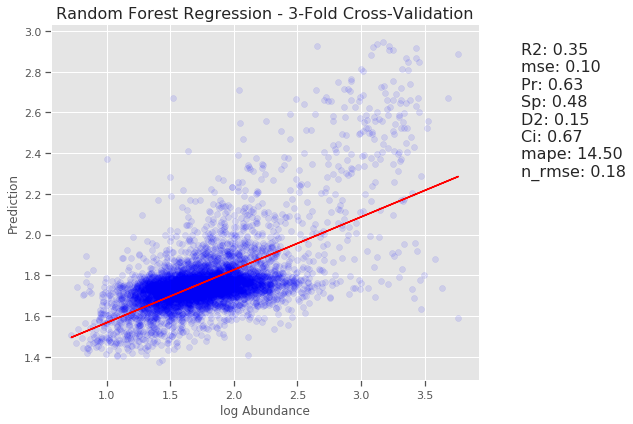

In [17]:
# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('log Abundance')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
oof_df = pd.DataFrame()
oof_df['oof_mRNAabundance']=all_predictions

In [19]:

    
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

In [20]:
#shap.summary_plot??

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


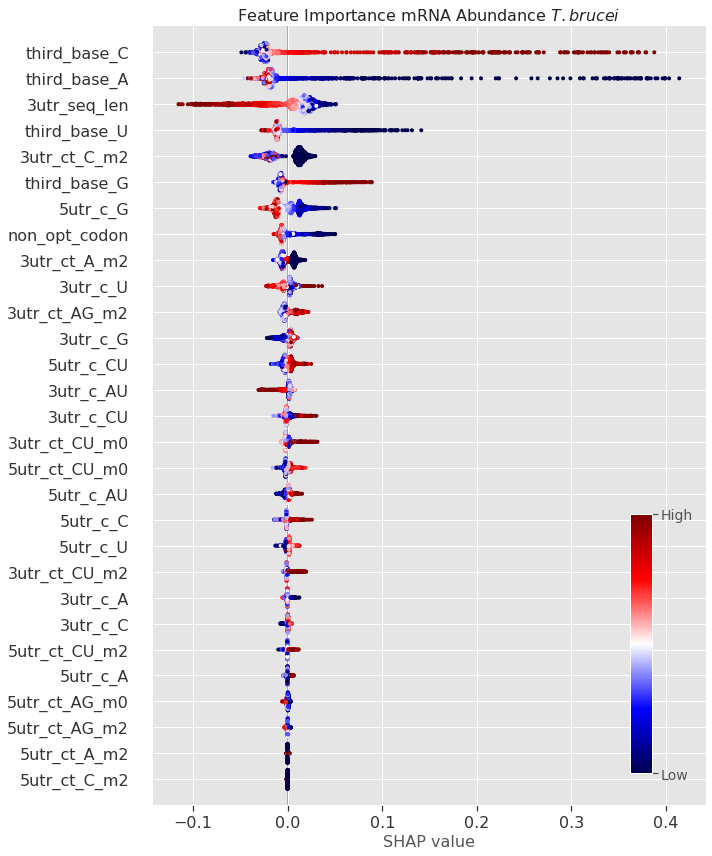

In [21]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance mRNA Abundance $\it{T. brucei}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TB_MRNA_abundance.png')
plt.savefig('UTR_seismic_TB_MRNA_abundance.svg')

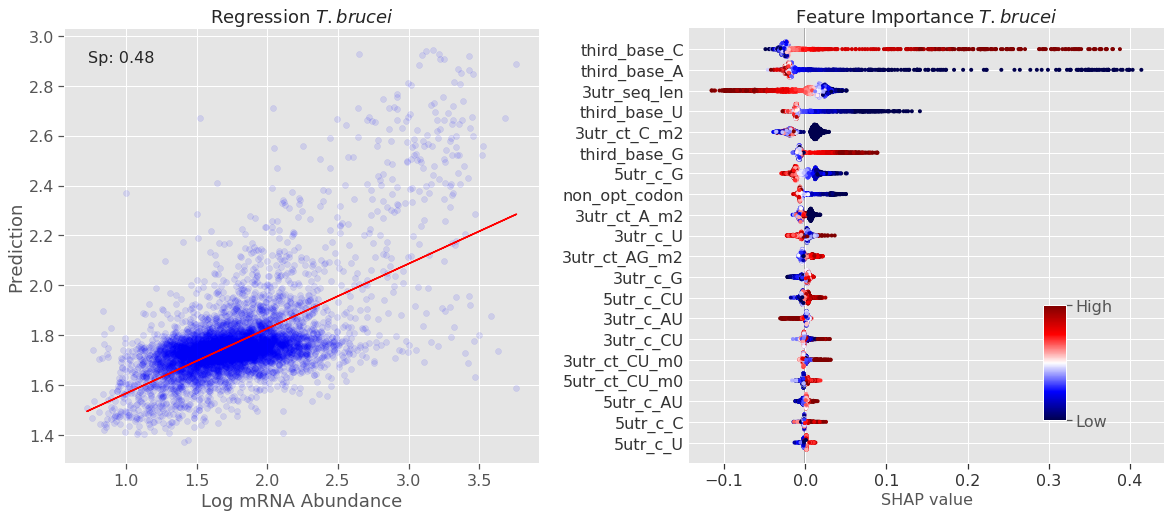

In [22]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions,  c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Log mRNA Abundance', fontsize=18)
#axes[0].set_title('Regression T. brucei', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=16)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

plt.savefig('Tb_mRNA_Abundance.png', bbox_inches='tight', dpi=300)
plt.savefig('Tb_mRNA_Abundance.svg', bbox_inches='tight')
plt.show()

In [23]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(regr, random_state=42, n_iter=10)

perm.fit(X_test, y_test.values, cv=3)           
    #visualize the output
n = eli5.show_weights(perm, feature_names = list(X_test.columns), 
                  top=500, show_feature_values=True)
    
eliDf = pd.DataFrame()
eliDf['fimp']=perm.feature_importances_#*100
eliDf['fimp_std']=perm.feature_importances_std_#*100
eliDf['f']=X.columns
eliDf.sort_values(by='fimp',ascending=False).head(20)

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


,fimp,fimp_std,f
27,0.122328,0.006849,third_base_C
24,0.115200,0.004472,third_base_A
11,0.045051,0.003857,utr_3_seq_len
25,0.023381,0.001494,third_base_T
26,0.014498,0.001490,third_base_G
7,0.011324,0.001494,utr_3_count_tracts_C_mismatch_2
1,0.007911,0.000945,utr_3_count_T
15,0.007573,0.001679,utr_5_count_G
28,0.006134,0.001069,non_optimal_codon
3,0.005267,0.000272,utr_3_count_G


In [24]:
#pd.concat([results_df.mean(),results_df.std()],axis=1)

In [25]:
#results_df['analysis_sp']='TB'
#results_df['analysis_type']='Abundance_All'
#results_df.to_csv('stats_TB_Abundance_All.csv')
#print("Average Sp: {:.4f} ± {:.4f}".format(
#    results_df['Sp'].mean(), results_df['Sp'].std()))

In [26]:
results_df = repeated_analysis(X, y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_All'
results_df.to_csv('stats_TB_Abundance_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_utr'
results_df.to_csv('stats_TB_Abundance_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='Abundance_codon'
results_df.to_csv('stats_TB_Abundance_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))



  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.4701 ± 0.0171


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.3301 ± 0.0173


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]

Average Sp: 0.3620 ± 0.0149


In [27]:
X=df.drop(to_drop, axis=1).drop(corr_to_drop, axis=1)
y=df['TE']

Fold 1 - R2: 0.3591, RMSE: 0.1398
Fold 2 - R2: 0.3488, RMSE: 0.1419
Fold 3 - R2: 0.3608, RMSE: 0.1379

Overall Metrics:
Mean R2: 0.3562 ± 0.0065
Mean RMSE: 0.1398 ± 0.0020


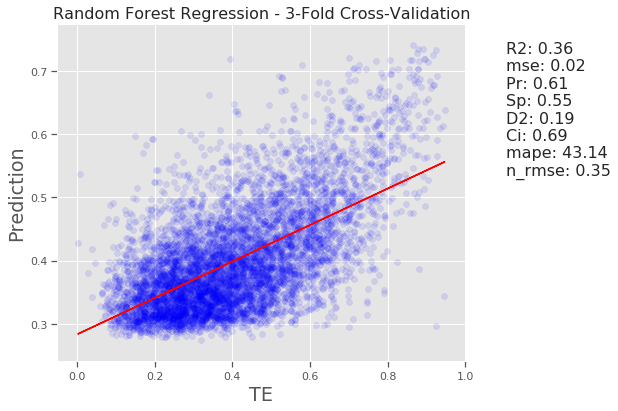

In [28]:
# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']



# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('TE')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



In [29]:
oof_df['oofs_TE']=all_predictions

In [30]:
X_test.shape

(2186, 29)

In [31]:
#X_test['good']

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


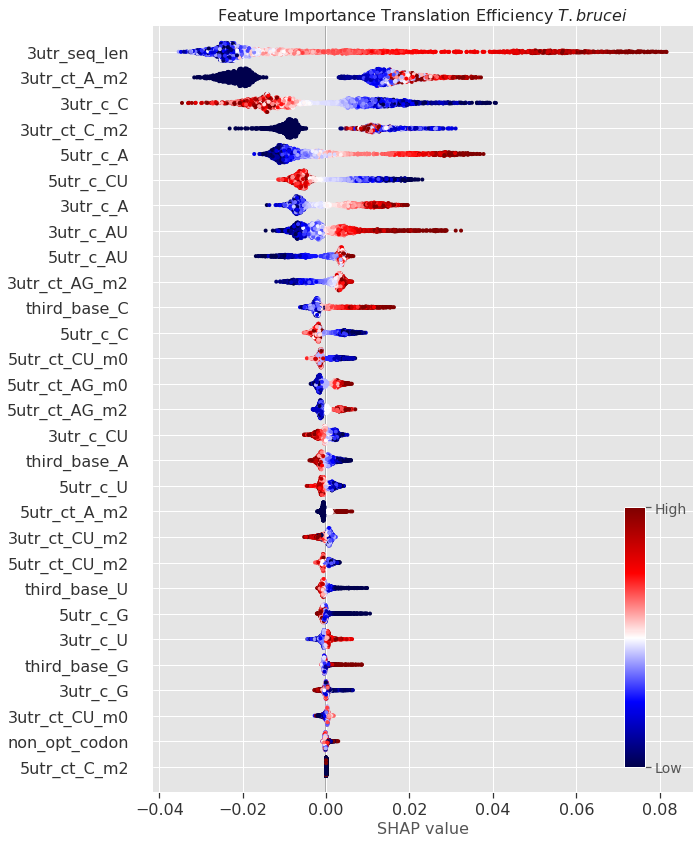

In [32]:
import shap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

# Now we use the SHAP scoring system to visualise 
# the most important features for the model
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=feature_names,
                  max_display=50, show=False, color_bar=False)

# Get the current figure and axes
f = plt.gcf()
f.set_size_inches(10, 12)
ax = plt.gca()

# Customize the plot
plt.title('Feature Importance Translation Efficiency $\it{T. brucei}$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('SHAP value', fontsize=16)

my_cmap = plt.get_cmap('seismic')

# Change the colormap of the artists
for child in ax.get_children():
    if hasattr(child, "set_cmap"):
        child.set_cmap(my_cmap)

# Create the colorbar and adjust its size
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
cbar_ax = f.add_axes([0.88, 0.1, 0.03, 0.3])
cbar = f.colorbar(cm.ScalarMappable(norm=norm, cmap='seismic'), cax=cbar_ax, shrink=0.5)
cbar.set_ticks([-1, 1])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('UTR_seismic_TB_TE.png')
plt.savefig('UTR_seismic_TB_TE.svg')

In [33]:
feature_names = [multiple_replace(n) for n in list(X_test.columns)]

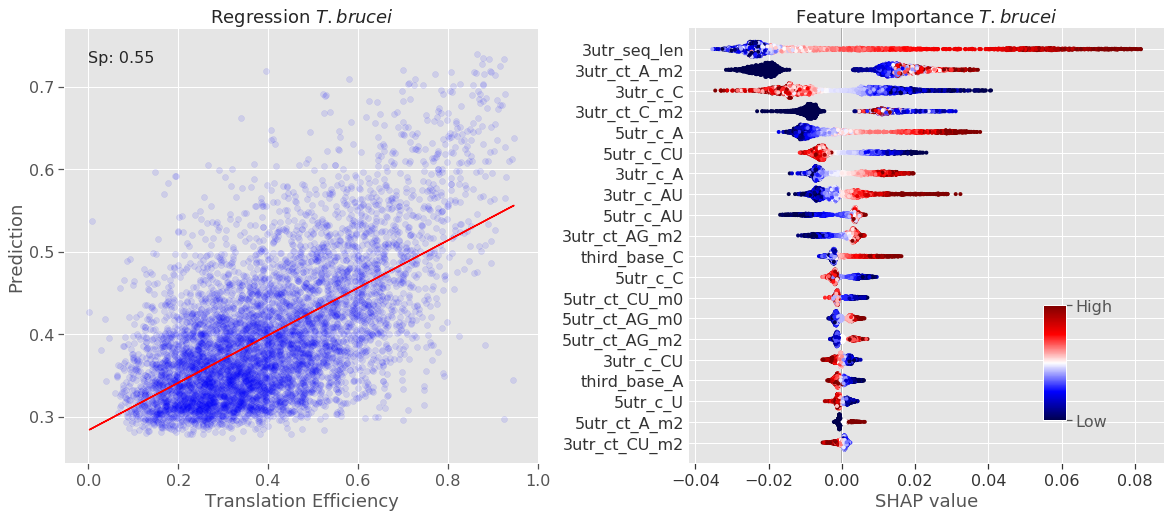

In [34]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Translation Efficiency', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
plt.savefig('Tb_TE.svg', bbox_inches='tight')
plt.show()

In [35]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(regr, random_state=42, n_iter=10)

perm.fit(X_test, y_test.values, cv=3)           
    #visualize the output
n = eli5.show_weights(perm, feature_names = list(X_test.columns), 
                  top=500, show_feature_values=True)
    
eliDf = pd.DataFrame()
eliDf['fimp']=perm.feature_importances_#*100
eliDf['fimp_std']=perm.feature_importances_std_#*100
eliDf['f']=X.columns
eliDf.sort_values(by='fimp',ascending=False).head(20)

,fimp,fimp_std,f
11,0.127002,0.007409,utr_3_seq_len
6,0.041025,0.004144,utr_3_count_tracts_A_mismatch_2
2,0.040446,0.003962,utr_3_count_C
12,0.024901,0.002042,utr_5_count_A
7,0.020641,0.002268,utr_3_count_tracts_C_mismatch_2
4,0.013135,0.001131,utr_3_count_AT
17,0.010520,0.002100,utr_5_count_CT
0,0.008202,0.001922,utr_3_count_A
16,0.007141,0.001092,utr_5_count_AT
27,0.006063,0.001045,third_base_C


In [36]:
#perm??

In [37]:
results_df = repeated_analysis(X, y)

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [38]:
pd.concat([results_df.mean(),results_df.std()],axis=1)

,0,1
R2,0.324062,0.012496
mse,0.020585,0.000422
Pr,0.602755,0.015927
Sp,0.541128,0.015684
D2,0.169908,0.007855
Ci,0.690018,0.005963
mape,44.247658,4.269563
n_rmse,0.359613,0.004205
Kn,0.380035,0.011925


In [39]:
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_All'
results_df.to_csv('stats_TB_TE_All.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

only_utr = [n for n in list(X.columns) if n.startswith('utr_')]
only_codon = [n for n in list(X.columns) if not n.startswith('utr_')]
results_df = repeated_analysis(X[only_utr], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_utr'
results_df.to_csv('stats_TB_TE_utr.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))

results_df = repeated_analysis(X[only_codon], y)
results_df['analysis_sp']='TB'
results_df['analysis_type']='TE_codon'
results_df.to_csv('stats_TB_TE_codon.csv')

print("Average Sp: {:.4f} ± {:.4f}".format(
    results_df['Sp'].mean(), results_df['Sp'].std()))



  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.5411 ± 0.0157


  0%|          | 0/100 [00:00<?, ?it/s]

Average Sp: 0.5387 ± 0.0148


100%|██████████| 100/100 [00:41<00:00,  2.43it/s]

Average Sp: 0.1615 ± 0.0198


In [40]:
protein_data = pd.read_csv('927 iBAQ.csv',index_col=['Gene_id'])
protein_data['iBAQ_BSF']=protein_data['bsf']
protein_data.head()

,Gene_acc,bsf,pcf,rank_bsf,rank_pcf,Desc,prot_group,iBAQ_BSF
Gene_id,,,,,,,,
Tb427.BES40.1,aa0aa,3.29,6.92,302.0,5941.0,Tb427.BES40.1,PG0,3.29
Tb927.10.10190,aa1000aa,3.18,3.66,14.0,1188.0,Leucine-rich repeat domain containing protein,PG569,3.18
Tb927.10.10200,aa1001aa,5.04,3.61,1733.0,817.0,"hypothetical protein, conserved",PG570,5.04
Tb927.10.10280,aa1002aa,5.87,5.77,3525.0,3939.0,Microtubule-associated repetitive protein 2,PG571,5.87
Tb927.10.10320,aa1003aa,7.04,6.63,5806.0,5598.0,"dynein light chain Tctex-type, putative",PG572,7.04


In [41]:
protein_data = df.join(protein_data[['iBAQ_BSF','prot_group']],how='left').drop_duplicates('prot_group',keep='first').dropna()
del protein_data['prot_group']
protein_data.head()

,TE,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,utr_3_count_AT,utr_3_count_CG,...,utr_5_count_tracts_AG_mismatch_0,third_base_A,third_base_T,third_base_G,third_base_C,non_optimal_codon,good,log_mean_ribo,log_mean_rna,iBAQ_BSF
Tb927.1.1000,0.238074,GGGAATCTTATTACTTTTGATCGATACCCGAGCACTATTTTGATGT...,ATGTTTGTGAAACTGTGTGTACTTTCCCTCTATTATCATTCACTTC...,ATGCGTCGCTTATTGTGTCTCTCACGCACTCGTGTTTCCTTCATGA...,0.179039,0.353712,0.213974,0.253275,0.532751,0.467249,...,0.013333,0.061758,0.097387,0.092637,0.081552,0.211401,True,1.316502,1.821702,3.36
Tb927.1.1010,0.258144,TGGACCTTGGAAGGGCTAAGAGTCACATTGCTCGCACGTTTGTACT...,CGATTCGAGTTAACTCTATTCCGTCCGTTCTCGTATCCCCCTTGTC...,ATGGACGGCAGTGAGTGCTTTCTCGTGACACCGACTCGGTGGGGGC...,0.261484,0.282686,0.222615,0.233216,0.544170,0.455830,...,0.013333,0.065278,0.097685,0.097222,0.073148,0.250000,True,1.114232,1.572689,4.25
Tb927.1.1020,0.370616,GGGTGTGGCAGGACACGTAACGTGAAGCAGCATAGAAATTGCTATA...,TATTACTTGCGTTAATATGTCGAAAGTGATCGCAAGGACGTTAGTT...,ATGGGTTGTGCAGGGAGTCAGCAGCAAAAACCTCGTAGCAATCAAA...,0.264234,0.271533,0.214599,0.249635,0.535766,0.464234,...,0.026667,0.064012,0.096019,0.092896,0.080406,0.309133,True,1.169043,1.399034,5.69
Tb927.1.1025,0.271056,TACATAGCCCGGAGAATGTTTGGTGGCCGCCAAAGTTGTCAAATTC...,CTCGCGTTGCGCATCGCACATAGGTCTGCATTCTTTCTTTTTCCCT...,ATGTTTCGCTCGTCGATGGTAGTGCGGTCCTTTACGCAGGAATCTT...,0.229508,0.319672,0.188525,0.262295,0.549180,0.450820,...,0.006667,0.055556,0.071429,0.107143,0.099206,0.285714,True,1.708861,2.138496,3.33
Tb927.1.1050,0.379694,TTAGGTAAAACAAAGGTCCCCATCCTGACACTTTTTTTTTGTTATA...,GCCGGTGGCTAGGACGAAAGTTGCTCGAGGAAAAGTGCTTGCTTTT...,ATGAATGTCACTAACCCCTCCACTGTCAGGTACGCCGATGCATTCA...,0.189286,0.332143,0.217857,0.260714,0.521429,0.478571,...,0.020000,0.060769,0.096515,0.090557,0.085493,0.245755,True,1.107819,1.320992,5.66


In [42]:
X.columns

Index(['utr_3_count_A', 'utr_3_count_T', 'utr_3_count_C', 'utr_3_count_G',
       'utr_3_count_AT', 'utr_3_count_CT', 'utr_3_count_tracts_A_mismatch_2',
       'utr_3_count_tracts_C_mismatch_2', 'utr_3_count_tracts_CT_mismatch_2',
       'utr_3_count_tracts_AG_mismatch_2', 'utr_3_count_tracts_CT_mismatch_0',
       'utr_3_seq_len', 'utr_5_count_A', 'utr_5_count_T', 'utr_5_count_C',
       'utr_5_count_G', 'utr_5_count_AT', 'utr_5_count_CT',
       'utr_5_count_tracts_A_mismatch_2', 'utr_5_count_tracts_C_mismatch_2',
       'utr_5_count_tracts_CT_mismatch_2', 'utr_5_count_tracts_AG_mismatch_2',
       'utr_5_count_tracts_CT_mismatch_0', 'utr_5_count_tracts_AG_mismatch_0',
       'third_base_A', 'third_base_T', 'third_base_G', 'third_base_C',
       'non_optimal_codon'],
      dtype='object')

In [43]:
X_train.shape,X_test.shape

((4374, 29), (2186, 29))

In [44]:
to_drop = ['TE', 'sequence_3p', 'sequence_5p', 'cds_seq', 'log_mean_ribo', 'log_mean_rna', 'good']

['TE',
 'sequence_3p',
 'sequence_5p',
 'cds_seq',
 'log_mean_ribo',
 'log_mean_rna',
 'good']

In [45]:
#to_drop2 = ['sequence_3p', 'sequence_5p', 'cds_seq', 'good']

In [46]:
#corr_to_drop

Fold 1 - R2: 0.5721, RMSE: 0.5950
Fold 2 - R2: 0.5667, RMSE: 0.6166
Fold 3 - R2: 0.5703, RMSE: 0.6019

Overall Metrics:
Mean R2: 0.5697 ± 0.0027
Mean RMSE: 0.6045 ± 0.0110


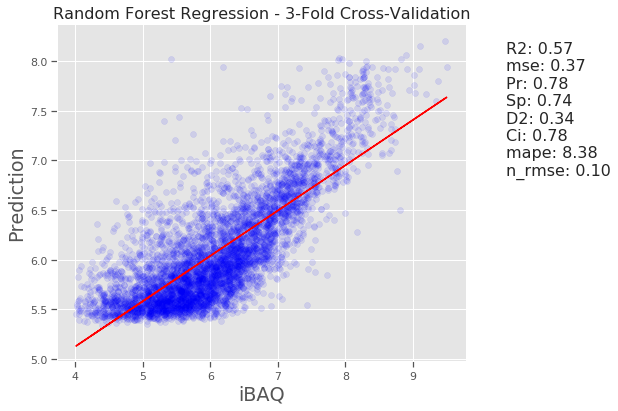

In [47]:
protein_data=protein_data[protein_data['iBAQ_BSF']>4]
X=protein_data.drop(to_drop2+['iBAQ_BSF'], axis=1).drop(corr_to_drop, axis=1)
y=protein_data['iBAQ_BSF']


# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

feature_names = [multiple_replace(n) for n in list(X_test.columns)]

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('iBAQ')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


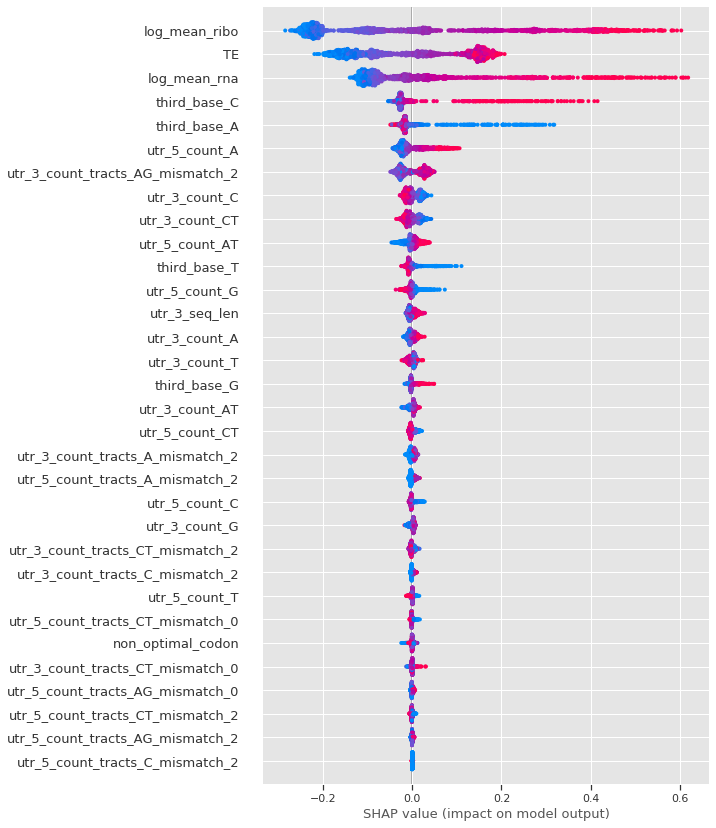

In [48]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  max_display=50, show=False, color_bar=False)

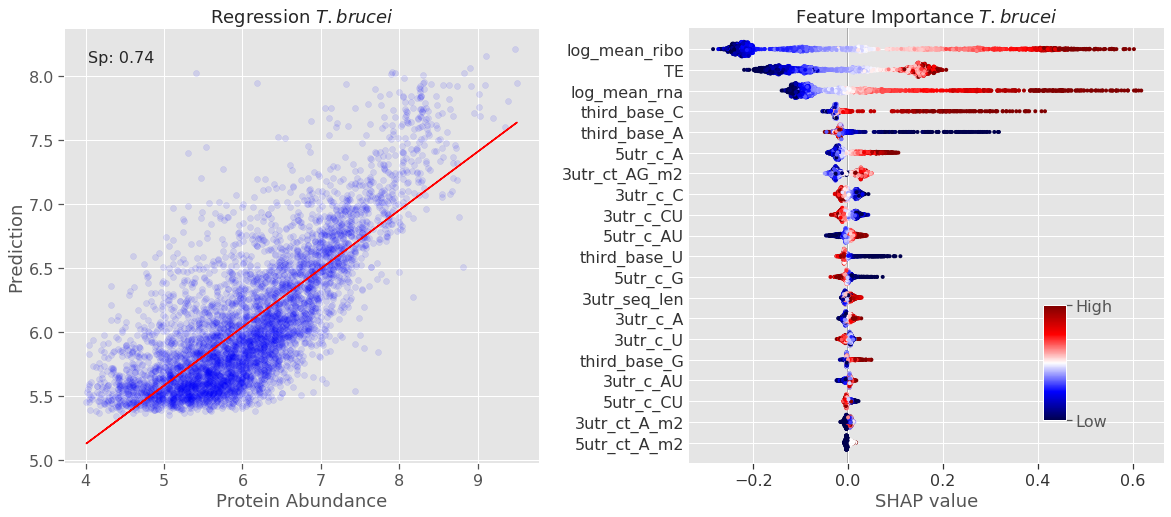

In [49]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Protein Abundance', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

feature_names = [multiple_replace(n) for n in list(X_test.columns)]
# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

#plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
#plt.savefig('Tb_TE.svg', bbox_inches='tight')
#plt.show()

Fold 1 - R2: 0.2512, RMSE: 0.7872
Fold 2 - R2: 0.2661, RMSE: 0.8025
Fold 3 - R2: 0.2451, RMSE: 0.7978

Overall Metrics:
Mean R2: 0.2541 ± 0.0108
Mean RMSE: 0.7958 ± 0.0079


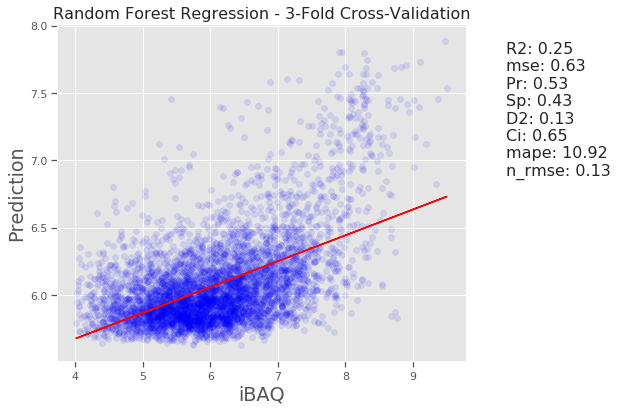

In [50]:
protein_data=protein_data[protein_data['iBAQ_BSF']>4]
X=protein_data.drop(to_drop+['iBAQ_BSF'], axis=1).drop(corr_to_drop, axis=1)
y=protein_data['iBAQ_BSF']


# Assuming X is a pandas DataFrame and y is a pandas Series
#all_predictions, all_true_values, regr, X_train, X_test, y_train, y_test = cross_validate_random_forest(X, y)
results = cross_validate_random_forest(X, y, n_splits=3)

# Access components from results dictionary
all_predictions = results['predictions']
all_true_values = results['true_values']
regr = results['model']
fold_metrics = results['fold_metrics']
X_train, y_train = results['train_data']
X_test, y_test = results['test_data']

feature_names = [multiple_replace(n) for n in list(X_test.columns)]

# Plotting
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(all_true_values, all_predictions , c='blue', alpha=0.1)
abline(all_true_values, all_predictions, ax, text_loc = [1.1, 0.95])
ax.set_ylabel('Prediction')
ax.set_xlabel('iBAQ')
ax.set_title('Random Forest Regression - 3-Fold Cross-Validation',fontsize=16)
plt.tight_layout()
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


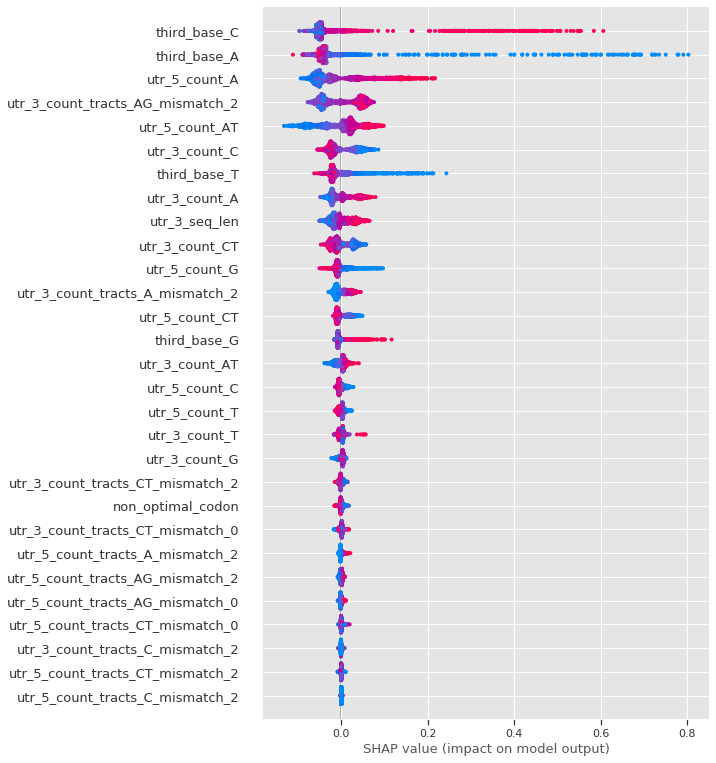

In [51]:
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_test)

# Create the SHAP summary plot
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  max_display=50, show=False, color_bar=False)

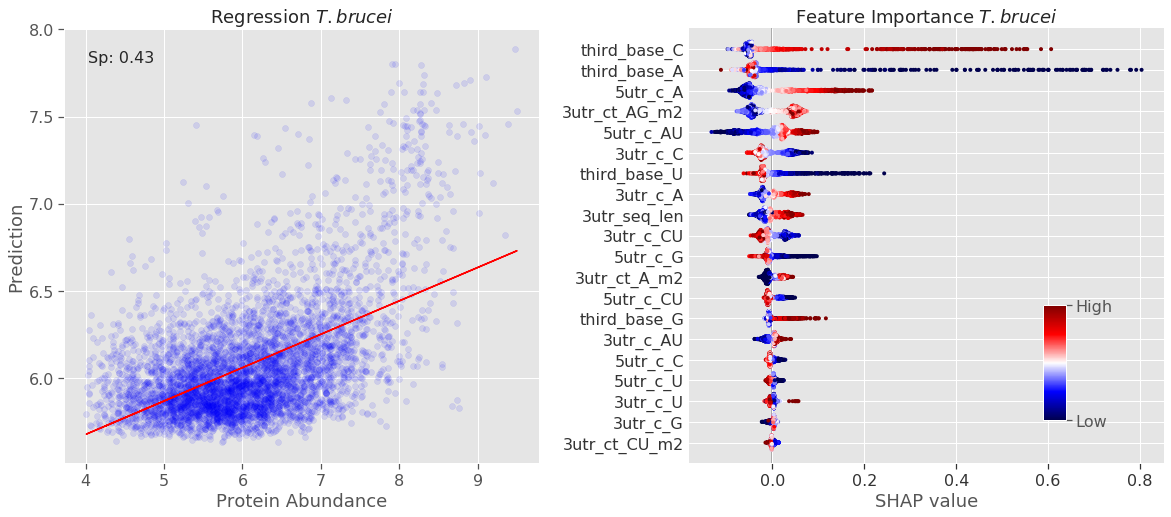

In [52]:
import matplotlib
fig = plt.figure(figsize=(16, 8))
# Increase right margin to accommodate colorbar
plt.subplots_adjust(left=0.1, right=0.85)  # Adjusted right margin

# Create gridspec without the colorbar position
gs = fig.add_gridspec(1, 2, width_ratios=[0.45, 0.45], wspace=0.4)
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
plt.rcParams.update({'font.size': 16})

# First plot (scatter plot)
axes[0].scatter(all_true_values, all_predictions, c='blue', alpha=0.1)
abline(all_true_values, all_predictions, axes[0], visualize = ['Sp'])
axes[0].set_ylabel('Prediction', fontsize=18)
axes[0].set_xlabel('Protein Abundance', fontsize=18)
axes[0].set_title('Regression $\it{T. brucei}$', fontsize=18)
axes[0].tick_params(axis='both', labelsize=16)

# Simple seismic colorbar first
my_cmap = plt.get_cmap('seismic')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)

feature_names = [multiple_replace(n) for n in list(X_test.columns)]
# SHAP plot in the middle
plt.sca(axes[1])  
shap.summary_plot(shap_values, 
                 X_test, 
                 feature_names=feature_names,
                 max_display=20, show=False, plot_size=(16,8), color_bar=False)
axes[1].tick_params(axis='both', labelsize=16)  
axes[1].set_title('Feature Importance $\it{T. brucei}$', fontsize=18)
axes[1].set_xlabel('SHAP value', fontsize=18)

# Apply colormap
for fc in fig.get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"): 
            fcc.set_cmap(my_cmap)

# Adjust positions manually for main plots
pos0 = axes[0].get_position()
pos1 = axes[1].get_position()
axes[0].set_position([pos0.x0, pos0.y0, pos0.width+0.1, pos0.height])
axes[1].set_position([pos1.x0+0.105, pos1.y0, pos1.width+0.1, pos1.height])
axes[1].tick_params(axis='y', pad=-15)
# Add colorbar after adjusting main plots
cax = fig.add_axes([0.95, 0.2, 0.02, 0.2])  # [left, bottom, width, height]
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=my_cmap, norm=norm)
cb.set_ticks([-1, 1])
cb.set_ticklabels(['Low', 'High'])
cb.ax.tick_params(labelsize=16)

#plt.savefig('Tb_TE.png', bbox_inches='tight', dpi=300)
#plt.savefig('Tb_TE.svg', bbox_inches='tight')
#plt.show()

In [53]:
# show versions of packages
# adopted from https://stackoverflow.com/questions/40428931/package-for-listing-version-of-packages-used-in-a-jupyter-notebook
import pkg_resources
import types
import sys
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
        yield name.lower()
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
modules = []
for m in sys.builtin_module_names:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'Python BuiltIn'))
        imports.remove(m.lower())

for m in pkg_resources.working_set:
    if m.project_name.lower() in imports and m.project_name!="pip":
        modules.append((m.project_name, m.version))
        imports.remove(m.project_name.lower())

for m in sys.modules:
    if m.lower() in imports and m !='builtins':
        modules.append((m,'unknown'))

# print('System=='+platform.system()+' '+platform.release()+'; Version=='+platform.version())
for r in modules:
    print("{}=={}".format(*r))

sys==Python BuiltIn
tqdm==4.36.1
shap==0.35.0
seaborn==0.9.0
scipy==1.3.2
scikit-learn==0.22
pandas==0.25.2
numpy==1.17.3
matplotlib==3.1.1
eli5==0.13.0
types==unknown
re==unknown
pkg_resources==unknown
concordance_index==unknown
repeated_analysis==unknown
cross_validate_random_forest==unknown


In [54]:
#conda create -n ml_utr python=3.8 matplotlib=3.5.1 numpy=1.21.6 \
#scipy=1.10.1 pandas=1.4.2 scikit-learn=1.0.2 shap=0.39.0 \
#eli5=0.13.0 seaborn=0.11.2 jupyterlab numba=0.53
#conda activate ml_utr
#jupyter lab

In [55]:
df = pd.read_pickle('ML_DATASET_TB.pkl')
df['good']=[True if n.startswith('Tb927.') else False for n in df.index.values] 
df=df[df['good']]
df=df.dropna()
print(df.shape)
df.head()

(6560, 53)


,mean_ribo,mean_rna,TE,sequence_3p,sequence_5p,cds_seq,utr_3_count_A,utr_3_count_T,utr_3_count_C,utr_3_count_G,...,utr_5_count_tracts_A_mismatch_0,utr_5_count_tracts_C_mismatch_0,utr_5_count_tracts_CT_mismatch_0,utr_5_count_tracts_AG_mismatch_0,third_base_A,third_base_T,third_base_G,third_base_C,non_optimal_codon,good
Tb927.3.5260,17.065100,45.851210,0.271235,TGAACAGTTGTGAAGTTAGGACGGGGCGTATGTTGCCTTCCTTTTG...,CTTCCTTTCTTTCTTTTTTCCCCCACCGCTTACTCTTTATCTATAC...,ATGTTAAGTTTTTTGATTGACTGCAGCGAAGACAAAACTGATCTCA...,0.173913,0.451691,0.200483,0.173913,...,0.000000,0.006667,0.020000,0.013333,0.097163,0.092908,0.081560,0.061702,0.355319,True
Tb927.3.5270,44.376535,130.104802,0.254334,AGTGGGCTAACAAACACGGTAGTCGCAACGATAATAACATCGAGCT...,GCCACACGGGGGCGAGCCGATTTGGGTGGTATTTTTTCCTCCCTTC...,ATGAGTAGTGAGAGATATGTGGATGGTGACCTCGGTGAGCCTTTTA...,0.205882,0.379412,0.200000,0.214706,...,0.000000,0.000000,0.013333,0.026667,0.085890,0.092025,0.102249,0.053170,0.306748,True
Tb927.3.5280,57.142513,135.942838,0.295944,TTGGTGTGGGAGAGAATGATTCTAAATGACAAGGGCTGATCATGTG...,AGTGTGCTCTGTTGACACTGTTGGTGTAATTAATCTATTTCAAATA...,ATGACCACGTTCAAGCGGGAAGACCTCCGTCGTGTCTTTTTTAGTG...,0.192802,0.406170,0.177378,0.223650,...,0.000000,0.000000,0.013333,0.000000,0.064350,0.102960,0.078507,0.087516,0.297297,True
Tb927.3.5290,11.424120,35.002112,0.246070,ATGCGTTGAAGAAGGAGAAGCGAATTTTAAGTTTCATGAGTGTGGT...,GTGCTGAATAAGCAGCCGTGTCCACAAAACGAGAAGGAGGCCGGTG...,ATGGGTCGGGCAACAGAGGCACAACGTGCCGAAATGGCAAAGGAGG...,0.190476,0.359307,0.229437,0.220779,...,0.006667,0.000000,0.006667,0.046667,0.080423,0.089242,0.102293,0.061376,0.307937,True
Tb927.3.5300,66.070601,65.183926,0.503378,TGCTATTGGTAGCATTTTCGTTGTTTCATTTCGTAACCTCCTTGAG...,AAAGGATAGCACAGGTCCTCCCCCCTTTTTTCTTGGGCAGTACTCT...,ATGTTATTCACCCGCTGTCTGCTAGCGGTCACGACAATCAACAGTA...,0.181132,0.362264,0.264151,0.192453,...,0.006667,0.006667,0.020000,0.033333,0.071291,0.055877,0.131021,0.075145,0.358382,True


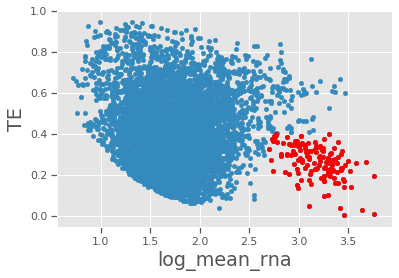

In [56]:
fig,ax=plt.subplots()
df['log_mean_rna']=np.log10(df['mean_rna'])
df.plot(kind='scatter',x='log_mean_rna',y='TE',ax=ax)
selection = df[(df['TE']<0.4)&(df['log_mean_rna']>2.7)].index.values
df.loc[selection].plot(kind='scatter',x='log_mean_rna',y='TE',ax=ax,c='r')

In [57]:
selection = df[(df['TE']<0.4)&(df['log_mean_rna']>2.7)]

ValueError: Cannot index with multidimensional key

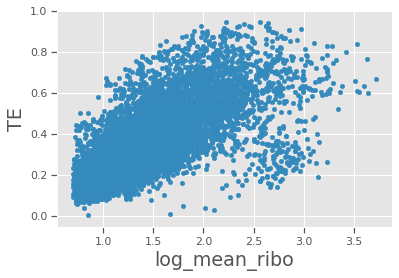

In [58]:
fig,ax=plt.subplots()
df['log_mean_ribo']=np.log10(df['mean_ribo'])
df.plot(kind='scatter',x='log_mean_ribo',y='TE',ax=ax)
df.loc[selection].plot(kind='scatter',x='log_mean_ribo',y='TE',ax=ax,c='r')

In [ ]:
df['non_optimal_codon'].plot(kind='hist',bins=50)

In [ ]:
#for n in df.loc[selection].index.values:
#    print(n)

In [ ]:
fig,ax=plt.subplots()
df['log_mean_ribo']=np.log10(df['mean_ribo'])
df.plot(kind='scatter',x='log_mean_ribo',y='TE',ax=ax,c=df['non_optimal_codon'],cmap='viridis')



In [ ]:
df['log_len_utr']=np.log10(df['sequence_3p'].str.len())

In [ ]:
fig,ax=plt.subplots(figsize=(12,4))
df.plot(kind='hist',histtype='step', y='log_len_utr',ax=ax,color='b',normed=True,label='all',bins=15)
df.loc[selection].plot(kind='hist',histtype='step', y='log_len_utr',ax=ax,color='r',normed=True,label='ribo',bins=15)

In [ ]:
fig,ax=plt.subplots(figsize=(12,4))
df.plot(kind='hist',histtype='step', y='non_optimal_codon',ax=ax,color='b',normed=True,label='all',bins=20)
df.loc[selection].plot(kind='hist',histtype='step', y='non_optimal_codon',ax=ax,color='r',normed=True,label='ribo',bins=15)

In [ ]:
fig,ax=plt.subplots()

df.plot(kind='scatter',x='non_optimal_codon',y='log_len_utr',ax=ax)
df.loc[selection].plot(kind='scatter',x='non_optimal_codon',y='log_len_utr',ax=ax,c='r')